In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import os


# Define the color palette using Plotly's qualitative colors
plotly_colors = px.colors.qualitative.Plotly
sns.set_palette(plotly_colors)

## Import Data

In [2]:
from importlib import resources as impresources
from recurrent_health_events_prediction import configs
import yaml

with open((impresources.files(configs) / 'data_config.yaml')) as f:
    data_config = yaml.safe_load(f)
training_data_config = data_config["training_data"]["mimic"]
training_data_path = training_data_config["preprocessed_path"]
print(f"Loading training data from {training_data_path}")


Loading training data from /workspaces/master-thesis-recurrent-health-events-prediction/data/mimic-iii-preprocessed/copd_heart_failure


In [3]:
subdir = "mimic_cleaned"
training_data_path = os.path.join(training_data_path, subdir)
print(f"Loading data from {training_data_path}")

Loading data from /workspaces/master-thesis-recurrent-health-events-prediction/data/mimic-iii-preprocessed/copd_heart_failure/mimic_cleaned


In [4]:
all_events_df = pd.read_csv(training_data_path + '/all_events.csv')
all_events_df['ADMITTIME'] = pd.to_datetime(all_events_df['ADMITTIME'])
all_events_df['DISCHTIME'] = pd.to_datetime(all_events_df['DISCHTIME'])
all_events_df['DOD'] = pd.to_datetime(all_events_df['DOD'])

In [5]:
all_events_df.sort_values(by=['SUBJECT_ID', 'ADMITTIME'], inplace=True)

In [6]:
def classify_event(row):
    if row['READMISSION_EVENT'] == 1:
        return 'Readmission after Discharge'
    elif row['IN_HOSP_DEATH_EVENT'] == 1:
        return 'In-Hospital Death'
    elif row['AFTER_HOSP_DEATH_EVENT'] == 1:
        return 'Death After Hospital Discharge'
    else:
        return 'No Readmission or No Death after Discharge'

all_events_df['EVENT_TYPE'] = all_events_df.apply(classify_event, axis=1)

In [7]:
from recurrent_health_events_prediction.visualization.utils import plot_subject_evolution

plot_subject_evolution(
    all_events_df,
    29633,
    features_to_plot=[
        'HOSPITALIZATION_DAYS', 'DAYS_IN_ICU', 'DAYS_UNTIL_NEXT_HOSPITALIZATION',
    ],
    textposition="auto",
    extend_time_horizon_by=90
)

## Extract Sequences

In [8]:
def define_state(row):
    if row['READMISSION_EVENT'] == 1:
        if row['DAYS_UNTIL_NEXT_HOSPITALIZATION'] > 120:
            return '120+'
        elif row['DAYS_UNTIL_NEXT_HOSPITALIZATION'] <= 90 and row['DAYS_UNTIL_NEXT_HOSPITALIZATION'] > 30:
            return '30-120'
        elif row['DAYS_UNTIL_NEXT_HOSPITALIZATION'] <= 30:
            return '<30'
    else:
        return '120+'

In [9]:
all_events_df['READMISSION_STATE'] = all_events_df.apply(define_state, axis=1)
all_events_df['READMISSION_STATE'] = pd.Categorical(
    all_events_df['READMISSION_STATE'],
    categories=['<30', '30-120', '120+'],
    ordered=True
)


In [10]:
all_events_df['NUM_EVENTS'] = all_events_df.groupby('SUBJECT_ID')['HADM_ID'].transform('count')
all_events_df['NUM_EVENTS'] = all_events_df['NUM_EVENTS'].astype(int)
all_events_df[['SUBJECT_ID', 'HADM_ID', 'EVENT_TYPE', 'READMISSION_STATE', 'NUM_EVENTS']].head()

,SUBJECT_ID,HADM_ID,EVENT_TYPE,READMISSION_STATE,NUM_EVENTS
0,21,109451,No Readmission or No Death after Discharge,120+,1
1,26,197661,Death After Hospital Discharge,120+,1
2,30,104557,No Readmission or No Death after Discharge,120+,1
3,33,176176,No Readmission or No Death after Discharge,120+,1
4,34,115799,No Readmission or No Death after Discharge,120+,1


In [11]:
patients_with_seq_gt_2_mask = (all_events_df['NUM_EVENTS'] >= 2)
patients_with_seq_gt_2_df = all_events_df[patients_with_seq_gt_2_mask]

In [12]:
patients_with_seq_gt_2_df = patients_with_seq_gt_2_df.sort_values(by=['SUBJECT_ID', 'ADMITTIME'])

In [13]:
patients_with_seq_gt_2_df[['SUBJECT_ID', 'DAYS_UNTIL_NEXT_HOSPITALIZATION', 'READMISSION_STATE']].head()

,SUBJECT_ID,DAYS_UNTIL_NEXT_HOSPITALIZATION,READMISSION_STATE
12,107,2474.120833,120+
13,107,160.221528,120+
39,236,222.811111,120+
40,236,1361.902778,120+
42,249,1860.222917,120+


In [14]:
patients_with_seq_gt_2_df['READMISSION_STATE'].value_counts(normalize=True).sort_index()

READMISSION_STATE
<30       0.256584
30-120    0.213820
120+      0.529597
Name: proportion, dtype: float64

## Analysis of Markov Memory and Predictability in Readmission States

In this analysis, we explore the **sequential dynamics** of patient readmission states by:

1. **Comparing first- and second-order Markov transition probabilities** to assess whether the process exhibits significant "memory" beyond the current state.
2. **Calculating the entropy of next states** to measure how predictable the system is and compare it to the entropy of an independent (random) process.


In [15]:
states_to_consider = ['<30', '30-120', '120+']
only_states_to_consider = True

In [16]:
markov_df = patients_with_seq_gt_2_df.copy()
# Assume df is sorted by subject and time as before
# Create state transition columns
markov_df['NEXT_STATE'] = markov_df.groupby('SUBJECT_ID')['READMISSION_STATE'].shift(-1)
markov_df['CURRENT_STATE'] = markov_df['READMISSION_STATE']
markov_df['PREV_STATE'] = markov_df.groupby('SUBJECT_ID')['READMISSION_STATE'].shift(1)

mask = markov_df['CURRENT_STATE'].isin(states_to_consider) & markov_df['NEXT_STATE'].isin(states_to_consider)
if only_states_to_consider:
    markov_df = markov_df[mask]

In [17]:
# Drop rows where previous or next state is missing
markov_df = markov_df.dropna(subset=['PREV_STATE', 'CURRENT_STATE', 'NEXT_STATE'])

# Calculate first-order transition probabilities
first_order_df = pd.crosstab(
    markov_df['CURRENT_STATE'], 
    markov_df['NEXT_STATE'], 
    normalize='index'
)

# Calculate second-order transition probabilities
second_order_df = markov_df.groupby(
    ['PREV_STATE', 'CURRENT_STATE', 'NEXT_STATE']
).size().unstack(fill_value=0)
second_order_df = second_order_df.div(second_order_df.sum(axis=1), axis=0)

/tmp/ipykernel_4105/3349036067.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [18]:
second_order_df.columns

CategoricalIndex(['<30', '30-120', '120+'], categories=['<30', '30-120', '120+'], ordered=True, dtype='category', name='NEXT_STATE')

In [19]:
print("Number of unique sequences:", markov_df['SUBJECT_ID'].nunique())
print("Number of transitions:", len(markov_df))

Number of unique sequences: 608
Number of transitions: 1367


#### First Order Analysis

<Axes: xlabel='NEXT_STATE', ylabel='CURRENT_STATE'>

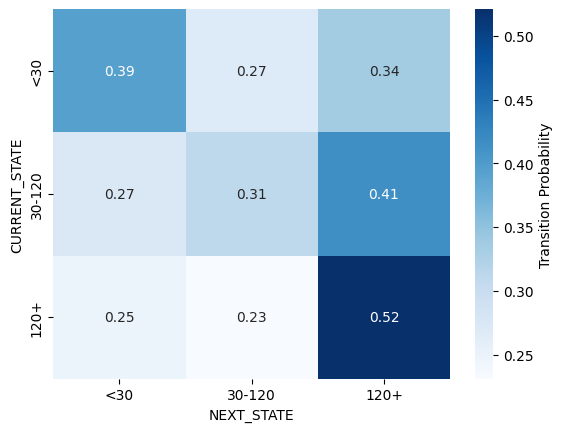

In [20]:
sns.heatmap(first_order_df,
            annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Transition Probability'})

In [21]:
first_order_df

NEXT_STATE,<30,30-120,120+
CURRENT_STATE,,,
<30,0.394667,0.269333,0.336000
30-120,0.273775,0.311239,0.414986
120+,0.248062,0.231008,0.520930


#### Second Order Analysis

In [22]:
print(second_order_df.sort_index(level=[1, 0]))

NEXT_STATE                     <30    30-120      120+
PREV_STATE CURRENT_STATE                              
<30        <30            0.504132  0.214876  0.280992
30-120     <30            0.369048  0.309524  0.321429
120+       <30            0.329412  0.288235  0.382353
<30        30-120         0.260870  0.358696  0.380435
30-120     30-120         0.329787  0.319149  0.351064
120+       30-120         0.248447  0.279503  0.472050
<30        120+           0.268908  0.277311  0.453782
30-120     120+           0.214286  0.150794  0.634921
120+       120+           0.252500  0.242500  0.505000


### 1. Does the process exhibit significant second-order memory?

To determine whether knowing both the previous and current state improves our ability to predict the next state (i.e., whether the process is truly "second-order"), we compare the **second-order** transition probabilities with the **first-order** transition probabilities using **Kullback-Leibler (KL) divergence**. It quantifies in this case how much information the previous state adds to the prediction of the next state (together with the current one).

- **Low KL divergence** indicates little additional information is gained from the previous state, supporting a first-order Markov process.
- **High KL divergence** suggests the previous state provides additional predictive power, indicating second-order memory.


In [23]:
import numpy as np

kl_list = []
for (prev_state, curr_state), row in second_order_df.iterrows():
    p = row[states_to_consider].values
    q = first_order_df.loc[curr_state].values
    p = np.clip(p, 1e-12, 1)  # avoid log(0)
    q = np.clip(q, 1e-12, 1)
    kl = np.sum(p * np.log(p / q))
    kl_list.append(kl)

mean_kl = np.mean(kl_list)
print(f"Mean KL divergence (second vs. first order): {mean_kl:.4f}")

Mean KL divergence (second vs. first order): 0.0112


**Interpretation:**

- If the **mean KL divergence** is close to 0 (for example, < 0.05), the process is well-described by a first-order Markov model.
- If it is much higher, then second-order (memory) effects are present and should be considered in your modeling.


### 2. How predictable are the next states? (Entropy Analysis)

To further characterize the process, we calculate the **Shannon entropy** of the next state distribution:
- **High entropy:** More random, less predictable.
- **Low entropy:** More structure, greater predictability.

We calculate entropy for both first-order and second-order models. If entropy drops substantially from first to second order, it means including the previous state adds a lot of predictive power.


In [24]:
first_order_df

NEXT_STATE,<30,30-120,120+
CURRENT_STATE,,,
<30,0.394667,0.269333,0.336000
30-120,0.273775,0.311239,0.414986
120+,0.248062,0.231008,0.520930


In [25]:
from scipy.stats import entropy

# First-order entropy: for each READMISSION_STATE
first_order_entropies = first_order_df.apply(lambda row: entropy(row[states_to_consider].values), axis=1)
first_order_entropies = first_order_entropies.sort_index()
current_state_probs = markov_df["CURRENT_STATE"].value_counts(normalize=True).sort_index()
weighted_first_order_entropy = (current_state_probs * first_order_entropies).sum()

# Second-order entropy: for each (PREV_STATE, READMISSION_STATE)
#second_order_entropies = second_order_filtered_df.apply(lambda row: entropy(row[states_to_consider].values), axis=1)

# Marginal entropy (fully independent process)
next_state_counts = markov_df['NEXT_STATE'].value_counts(normalize=True).drop('death', errors='ignore')
marginal_entropy = entropy(next_state_counts[states_to_consider].values)

print(f"Marginal entropy (no memory): {marginal_entropy:.4f}")
print(f"Weighted mean entropy (first-order): {weighted_first_order_entropy:.4f}")
#print(f"Mean entropy (second-order): {second_order_entropies.mean():.4f}")

Marginal entropy (no memory): 1.0716
Weighted mean entropy (first-order): 1.0562


In [26]:
print("First order entropies:")
first_order_entropies.name = 'First Order Entropy'
first_order_entropies

First order entropies:


CURRENT_STATE
<30       1.086696
30-120    1.082922
120+      1.024033
Name: First Order Entropy, dtype: float64

In [27]:
print("Marginal probabilities of next states:")
next_state_counts

Marginal probabilities of next states:


NEXT_STATE
120+      0.443307
<30       0.294806
30-120    0.261887
Name: proportion, dtype: float64

In [28]:
markov_df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ETHNICITY,DISCHARGE_LOCATION,INSURANCE,HOSPITALIZATION_DAYS,NUM_COMORBIDITIES,...,IS_LAST_EVENT,IS_HISTORICAL_EVENT,READMISSION_TIME_CAT,READMISSION_TIME_CAT_ENCODED,EVENT_TYPE,READMISSION_STATE,NUM_EVENTS,NEXT_STATE,CURRENT_STATE,PREV_STATE
46,256,153771,2166-07-21 23:38:00,2166-07-28 12:45:00,EMERGENCY,WHITE,SNF,Medicare,6.546528,3,...,0,1,120+,2,No Readmission or No Death after Discharge,120+,3,30-120,120+,120+
57,305,108015,2125-12-31 18:40:00,2126-01-10 11:30:00,EMERGENCY,WHITE,SNF,Medicare,9.701389,4,...,0,1,120+,2,No Readmission or No Death after Discharge,120+,3,120+,120+,120+
75,353,108923,2151-03-28 16:01:00,2151-04-13 16:10:00,EMERGENCY,WHITE,HOME,Medicare,16.006250,4,...,0,1,30-120,1,Readmission after Discharge,30-120,4,30-120,30-120,120+
76,353,112976,2151-06-23 22:18:00,2151-07-04 13:22:00,EMERGENCY,WHITE,HOME,Medicare,10.627778,3,...,0,1,30-120,1,Readmission after Discharge,30-120,4,120+,30-120,30-120
81,357,145674,2198-08-02 04:49:00,2198-10-26 14:55:00,EMERGENCY,WHITE,REHAB/DISTINCT PART HOSP,Private,85.420833,5,...,0,1,0-30,0,Readmission after Discharge,<30,4,120+,<30,120+


### Chi-Squared Test of Independence (Excluding Death)

We test whether, **among the states `<30`, `30-90`, and `90+`**, the next state is independent of the current state (i.e., whether knowledge of the current state provides information about the next state, excluding cases involving death).

- **Null hypothesis (H0):** Next-state is independent of current state.
- **Alternative hypothesis (H1):** Next-state depends on current state.

If the p-value is **less than 0.05**, we reject H0 and conclude there is evidence of dependence.


In [29]:
valid_states = ['<30', '30-120', '120+']
filtered_df = markov_df[
    markov_df['READMISSION_STATE'].isin(valid_states) &
    markov_df['NEXT_STATE'].isin(valid_states)
]

contingency = pd.crosstab(
    filtered_df['READMISSION_STATE'],
    filtered_df['NEXT_STATE']
)
print(contingency)

NEXT_STATE         <30  30-120  120+
READMISSION_STATE                   
<30                148     101   126
30-120              95     108   144
120+               160     149   336


In [30]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi2 test statistic: {chi2:.4f}")
print(f"P-value: {p:.3e}")


Chi2 test statistic: 42.7761
P-value: 1.152e-08


There is evidence that the next state distribution is different depending on the current state (i.e., not independent).

Chi-squared test:
- Sensitive to any difference between observed and expected transitions.
- Even small but consistent differences (especially with a large sample size) will produce a highly significant result.
- Compares the full distribution, not just overall entropy.

Entropy difference:
- Measures average unpredictability. If every row (for each current state) has nearly the same next-state probabilities, entropy will barely change.
- If the distributions are similar but not identical, the entropy values will be close even if technically the distributions are not independent.

Statistically:
- The transition process is not strictly independent (the chi-squared test is very sensitive).

Practically:
- The amount of dependency is so small that it doesn’t help you predict much better (entropy barely drops).

**Chi-squared Test of Independence**

- Chi2 statistic: 42.7761
- p-value: < 0.0001

This test strongly rejects the null hypothesis of independence: the distribution of next states does depend on the current state (excluding death).

However, as shown by the entropy analysis, the practical information gained is extremely small; the next state is only slightly more predictable if the current state is known.

**Conclusion:**  
There is a statistically significant but practically weak dependence of next-state on current-state.
